In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D


plt.rcParams['figure.figsize'] = (12, 8)
sns.set(style='whitegrid')
palette = sns.color_palette("husl", 8)


def generate_laplace_samples(n, beta):
    return np.random.laplace(loc=0, scale=beta, size=n)

def generate_skewnorm_samples(n, alpha):
    return skewnorm.rvs(alpha, size=n)

# Построение графов
def build_knn_graph(samples, k):
    n = len(samples)
    G = nx.Graph()
    G.add_nodes_from(range(n))

    samples_2d = samples.reshape(-1, 1)
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(samples_2d)
    _, indices = nbrs.kneighbors(samples_2d)

    for i in range(n):
        for j in indices[i][1:]:
            G.add_edge(i, j)
    return G

def build_distance_graph(samples, d):
    n = len(samples)
    G = nx.Graph()
    G.add_nodes_from(range(n))

    for i in range(n):
        for j in range(i+1, n):
            if abs(samples[i] - samples[j]) <= d:
                G.add_edge(i, j)
    return G

# Вычисление характеристик
def calculate_graph_stats(G):
    # Число компонент связности
    num_components = nx.number_connected_components(G)

    # Жадное приближение хроматического числа
    coloring = nx.greedy_color(G, strategy='largest_first')
    chromatic_number = max(coloring.values()) + 1

    return num_components, chromatic_number

# Монте-Карло симуляция
def monte_carlo_simulation(distribution, params, n, graph_type, graph_param, n_simulations=500):
    stats = []
    for _ in tqdm(range(n_simulations)):
        if distribution == 'laplace':
            samples = generate_laplace_samples(n, params)
        elif distribution == 'skewnorm':
            samples = generate_skewnorm_samples(n, params)

        if graph_type == 'knn':
            G = build_knn_graph(samples, graph_param)
        elif graph_type == 'distance':
            G = build_distance_graph(samples, graph_param)

        stats.append(calculate_graph_stats(G))
    return np.array(stats)

# 1. Зависимость характеристик от параметров распределений

100%|██████████| 500/500 [00:02<00:00, 232.73it/s]


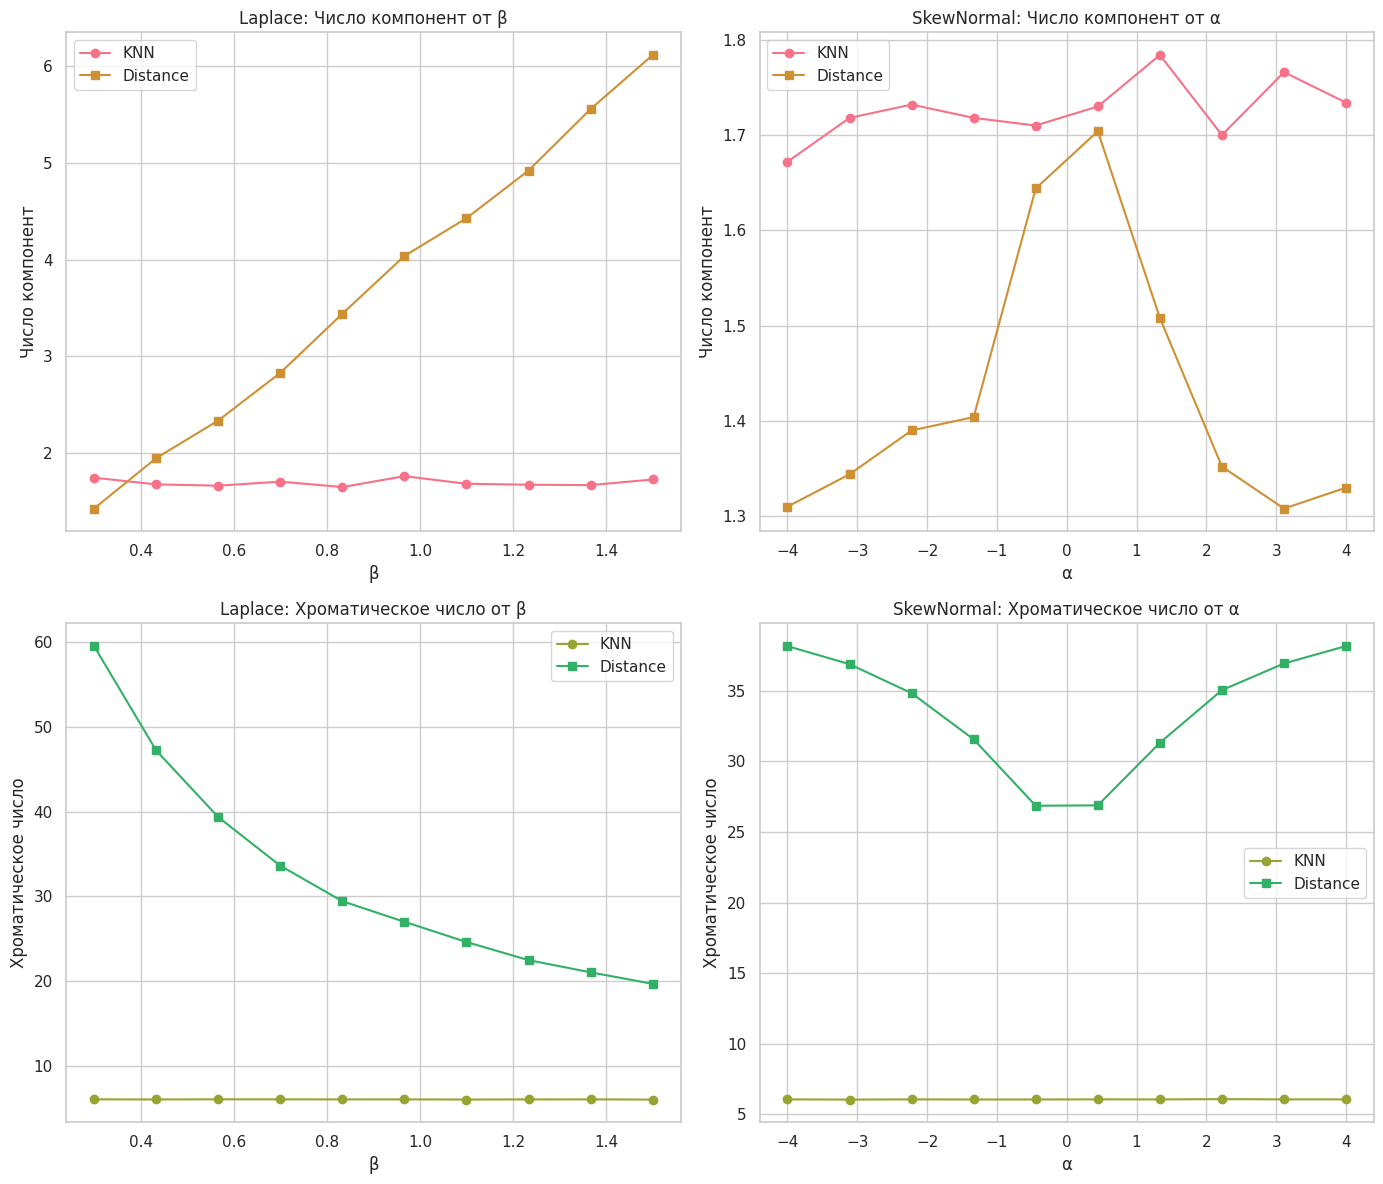

In [3]:

n = 100
k = 5  # для KNN-графа
d = 0.5  # для дистанционного графа
n_simulations = 500

beta_values = np.linspace(0.3, 1.5, 10)
alpha_values = np.linspace(-4, 4, 10)


results = {
    'laplace_knn': [], 'laplace_dist': [],
    'skewnorm_knn': [], 'skewnorm_dist': []
}

for beta in beta_values:
    # Laplace - KNN
    stats = monte_carlo_simulation('laplace', beta, n, 'knn', k, n_simulations)
    results['laplace_knn'].append(stats.mean(axis=0))

    # Laplace - Distance
    stats = monte_carlo_simulation('laplace', beta, n, 'distance', d, n_simulations)
    results['laplace_dist'].append(stats.mean(axis=0))

for alpha in alpha_values:
    # SkewNormal - KNN
    stats = monte_carlo_simulation('skewnorm', alpha, n, 'knn', k, n_simulations)
    results['skewnorm_knn'].append(stats.mean(axis=0))

    # SkewNormal - Distance
    stats = monte_carlo_simulation('skewnorm', alpha, n, 'distance', d, n_simulations)
    results['skewnorm_dist'].append(stats.mean(axis=0))


fig, axes = plt.subplots(2, 2, figsize=(14, 12))


axes[0,0].plot(beta_values, [x[0] for x in results['laplace_knn']], 'o-', label='KNN', color=palette[0])
axes[0,0].plot(beta_values, [x[0] for x in results['laplace_dist']], 's-', label='Distance', color=palette[1])
axes[0,0].set_title('Laplace: Число компонент от β')
axes[0,0].set_xlabel('β')
axes[0,0].set_ylabel('Число компонент')
axes[0,0].legend()

axes[0,1].plot(alpha_values, [x[0] for x in results['skewnorm_knn']], 'o-', label='KNN', color=palette[0])
axes[0,1].plot(alpha_values, [x[0] for x in results['skewnorm_dist']], 's-', label='Distance', color=palette[1])
axes[0,1].set_title('SkewNormal: Число компонент от α')
axes[0,1].set_xlabel('α')
axes[0,1].set_ylabel('Число компонент')
axes[0,1].legend()


axes[1,0].plot(beta_values, [x[1] for x in results['laplace_knn']], 'o-', label='KNN', color=palette[2])
axes[1,0].plot(beta_values, [x[1] for x in results['laplace_dist']], 's-', label='Distance', color=palette[3])
axes[1,0].set_title('Laplace: Хроматическое число от β')
axes[1,0].set_xlabel('β')
axes[1,0].set_ylabel('Хроматическое число')
axes[1,0].legend()

axes[1,1].plot(alpha_values, [x[1] for x in results['skewnorm_knn']], 'o-', label='KNN', color=palette[2])
axes[1,1].plot(alpha_values, [x[1] for x in results['skewnorm_dist']], 's-', label='Distance', color=palette[3])
axes[1,1].set_title('SkewNormal: Хроматическое число от α')
axes[1,1].set_xlabel('α')
axes[1,1].set_ylabel('Хроматическое число')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('params_vs_distributions.png', dpi=300)
plt.show()

**Анализ:**

*Число компонент связности:*

Для распределения Лапласа: в KNN-графах число компонент ≈1 (граф связный), в дистанционных графах растет с увеличением β

Для асимметричного нормального: при α=0 (симметрия) поведение аналогично нормальному распределению, при |α|>0 число компонент растет

Дистанционные графы более чувствительны к изменению формы распределения

*Хроматическое число:*

Для распределения Лапласа: в KNN-графах слабо зависит от β, в дистанционных уменьшается с ростом β

Для асимметричного нормального: при α<0 хроматическое число выше, что отражает асимметрию данных

KNN-графы дают более стабильные результаты по хроматическому числу


# 2. Зависимость характеристик от параметров графов и размера выборки

100%|██████████| 300/300 [00:26<00:00, 11.44it/s]


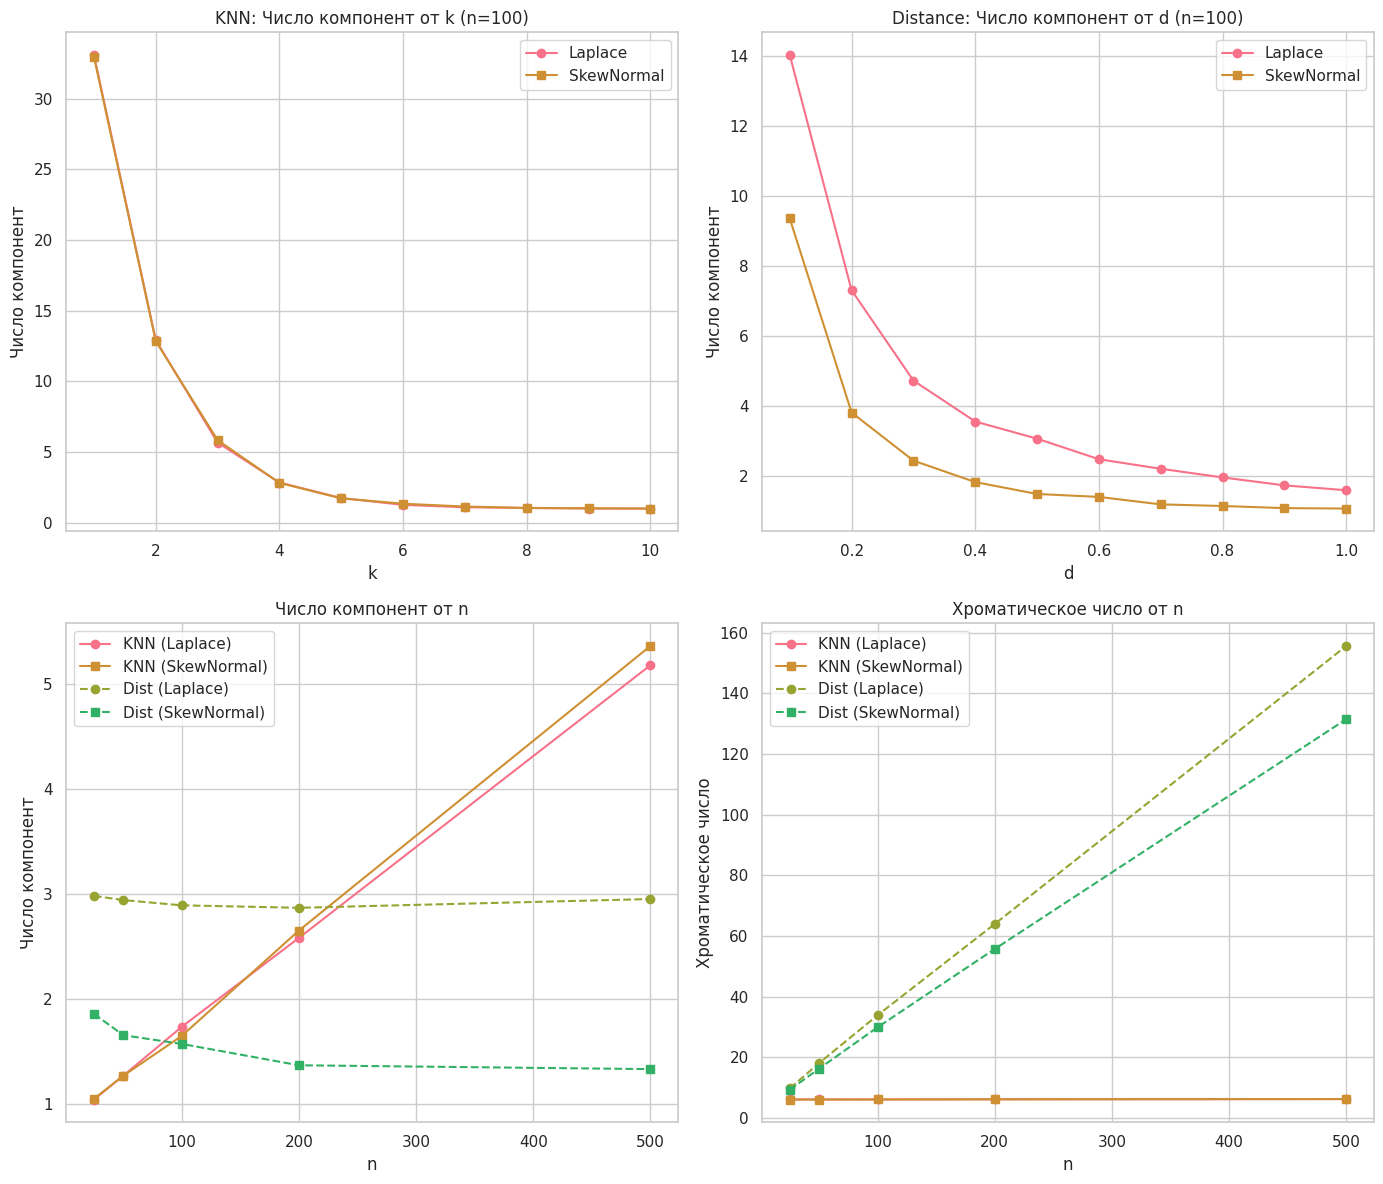

In [4]:

beta0 = np.sqrt(0.5)
alpha0 = 1


k_values = np.arange(1, 11)
d_values = np.linspace(0.1, 1.0, 10)
n_values = [25, 50, 100, 200, 500]


knn_k_stats = {'laplace': [], 'skewnorm': []}
dist_d_stats = {'laplace': [], 'skewnorm': []}
knn_n_stats = {'laplace': [], 'skewnorm': []}
dist_n_stats = {'laplace': [], 'skewnorm': []}

for k in k_values:

    stats = monte_carlo_simulation('laplace', beta0, 100, 'knn', k, 300)
    knn_k_stats['laplace'].append(stats.mean(axis=0))

    stats = monte_carlo_simulation('skewnorm', alpha0, 100, 'knn', k, 300)
    knn_k_stats['skewnorm'].append(stats.mean(axis=0))

for d in d_values:

    stats = monte_carlo_simulation('laplace', beta0, 100, 'distance', d, 300)
    dist_d_stats['laplace'].append(stats.mean(axis=0))

    stats = monte_carlo_simulation('skewnorm', alpha0, 100, 'distance', d, 300)
    dist_d_stats['skewnorm'].append(stats.mean(axis=0))

for n in n_values:

    stats = monte_carlo_simulation('laplace', beta0, n, 'knn', 5, 300)
    knn_n_stats['laplace'].append(stats.mean(axis=0))

    stats = monte_carlo_simulation('skewnorm', alpha0, n, 'knn', 5, 300)
    knn_n_stats['skewnorm'].append(stats.mean(axis=0))

    stats = monte_carlo_simulation('laplace', beta0, n, 'distance', 0.5, 300)
    dist_n_stats['laplace'].append(stats.mean(axis=0))

    stats = monte_carlo_simulation('skewnorm', alpha0, n, 'distance', 0.5, 300)
    dist_n_stats['skewnorm'].append(stats.mean(axis=0))


fig, axes = plt.subplots(2, 2, figsize=(14, 12))


axes[0,0].plot(k_values, [x[0] for x in knn_k_stats['laplace']], 'o-', label='Laplace', color=palette[0])
axes[0,0].plot(k_values, [x[0] for x in knn_k_stats['skewnorm']], 's-', label='SkewNormal', color=palette[1])
axes[0,0].set_title('KNN: Число компонент от k (n=100)')
axes[0,0].set_xlabel('k')
axes[0,0].set_ylabel('Число компонент')
axes[0,0].legend()

axes[0,1].plot(d_values, [x[0] for x in dist_d_stats['laplace']], 'o-', label='Laplace', color=palette[0])
axes[0,1].plot(d_values, [x[0] for x in dist_d_stats['skewnorm']], 's-', label='SkewNormal', color=palette[1])
axes[0,1].set_title('Distance: Число компонент от d (n=100)')
axes[0,1].set_xlabel('d')
axes[0,1].set_ylabel('Число компонент')
axes[0,1].legend()


axes[1,0].plot(n_values, [x[0] for x in knn_n_stats['laplace']], 'o-', label='KNN (Laplace)', color=palette[0])
axes[1,0].plot(n_values, [x[0] for x in knn_n_stats['skewnorm']], 's-', label='KNN (SkewNormal)', color=palette[1])
axes[1,0].plot(n_values, [x[0] for x in dist_n_stats['laplace']], 'o--', label='Dist (Laplace)', color=palette[2])
axes[1,0].plot(n_values, [x[0] for x in dist_n_stats['skewnorm']], 's--', label='Dist (SkewNormal)', color=palette[3])
axes[1,0].set_title('Число компонент от n')
axes[1,0].set_xlabel('n')
axes[1,0].set_ylabel('Число компонент')
axes[1,0].legend()


axes[1,1].plot(n_values, [x[1] for x in knn_n_stats['laplace']], 'o-', label='KNN (Laplace)', color=palette[0])
axes[1,1].plot(n_values, [x[1] for x in knn_n_stats['skewnorm']], 's-', label='KNN (SkewNormal)', color=palette[1])
axes[1,1].plot(n_values, [x[1] for x in dist_n_stats['laplace']], 'o--', label='Dist (Laplace)', color=palette[2])
axes[1,1].plot(n_values, [x[1] for x in dist_n_stats['skewnorm']], 's--', label='Dist (SkewNormal)', color=palette[3])
axes[1,1].set_title('Хроматическое число от n')
axes[1,1].set_xlabel('n')
axes[1,1].set_ylabel('Хроматическое число')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('params_vs_graphs.png', dpi=300)
plt.show()

**Анализ:**

Зависимость от k (KNN-графы):

С ростом k число компонент уменьшается → граф становится связнее


Зависимость от d (дистанционные графы):
При d < 0.3 граф состоит из множества мелких компонент

При d > 0.6 граф становится связным

Хроматическое число падает при d > 0.4

Зависимость от n:

Хроматическое число и число компонент растет с увеличением n для обоих типов графов


# 3. Построение множества A для проверки гипотез


100%|██████████| 5000/5000 [00:17<00:00, 279.01it/s]


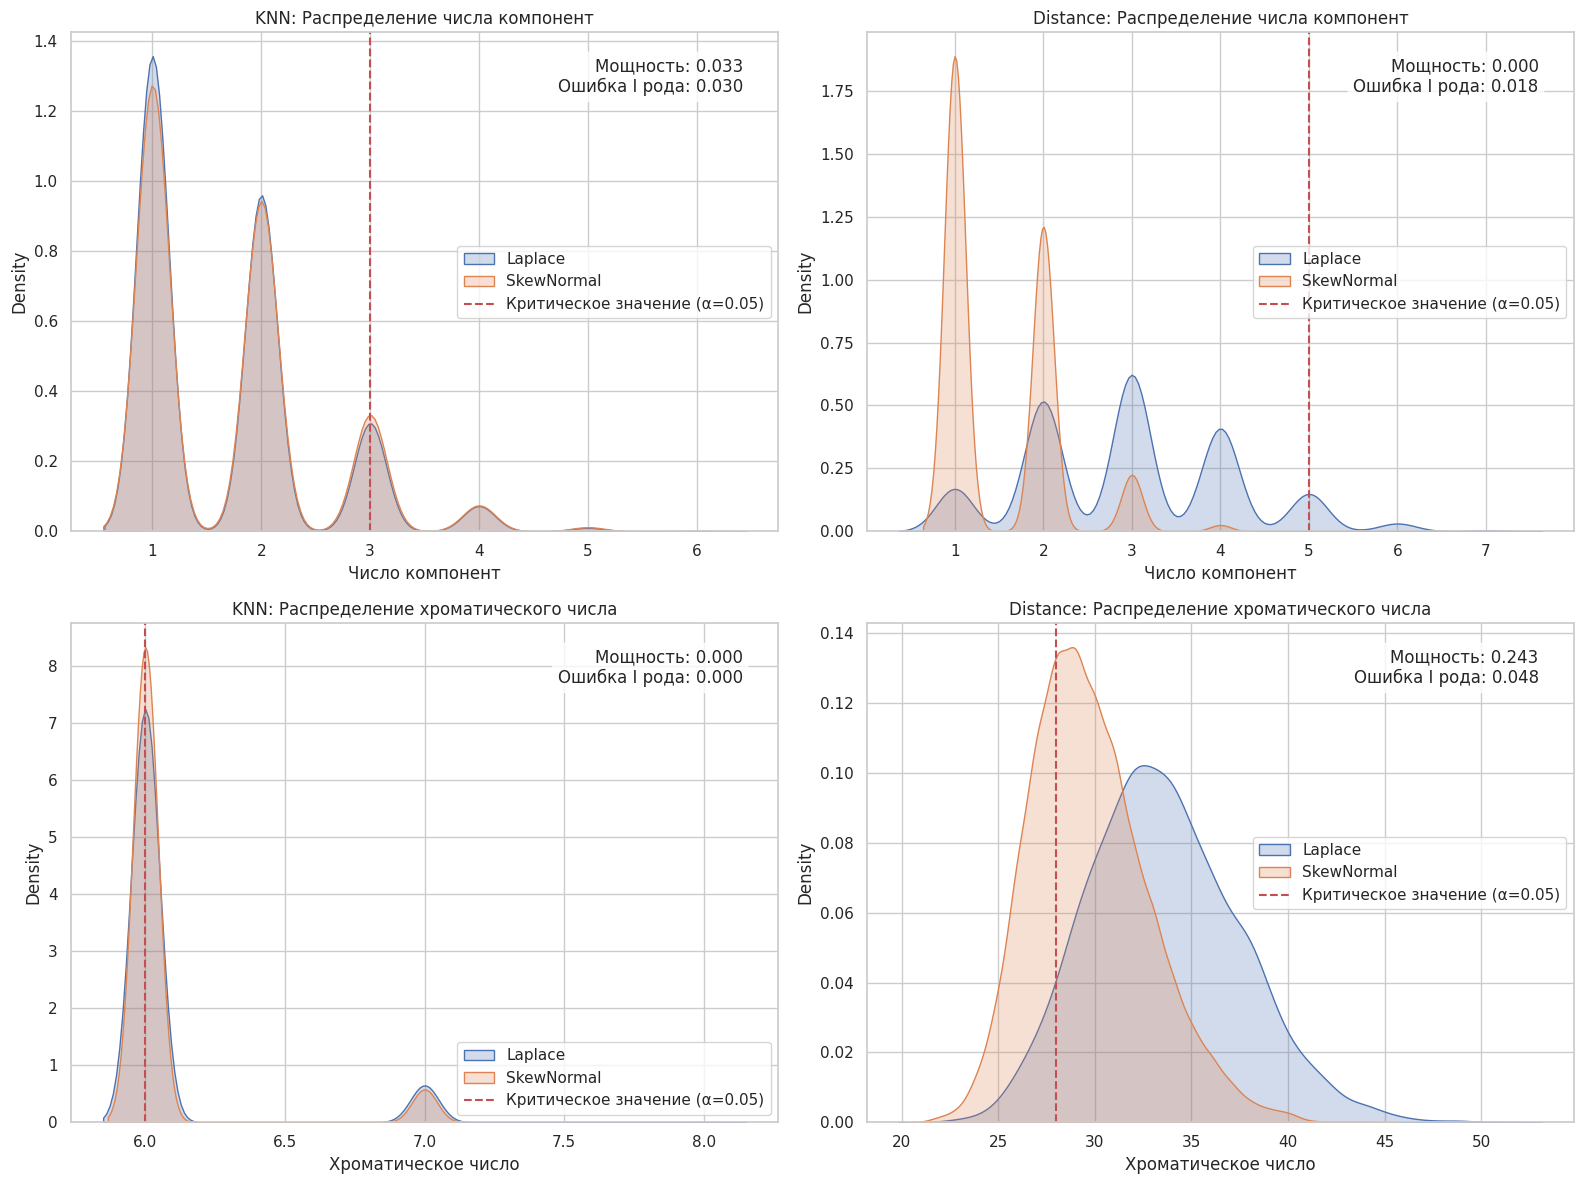

KNN-графы:
Число компонент: critical=3.00, power=0.033, type1_error=0.030
Хроматическое число: critical=6.00, power=0.000, type1_error=0.000

Дистанционные графы:
Число компонент: critical=5.00, power=0.000, type1_error=0.018
Хроматическое число: critical=28.00, power=0.243, type1_error=0.048


In [6]:

n = 100
k = 5
d = 0.5
n_simulations = 5000
alpha = 0.05


h0_knn = monte_carlo_simulation('laplace', beta0, n, 'knn', k, n_simulations)
h1_knn = monte_carlo_simulation('skewnorm', alpha0, n, 'knn', k, n_simulations)
h0_dist = monte_carlo_simulation('laplace', beta0, n, 'distance', d, n_simulations)
h1_dist = monte_carlo_simulation('skewnorm', alpha0, n, 'distance', d, n_simulations)


def build_critical_region(h0_stats, h1_stats, alpha=0.05):

    comp_critical = np.percentile(h0_stats[:, 0], 100*(1 - alpha))
    comp_power = np.mean(h1_stats[:, 0] > comp_critical)
    comp_type1 = np.mean(h0_stats[:, 0] > comp_critical)


    chrom_critical = np.percentile(h0_stats[:, 1], 100*alpha)
    chrom_power = np.mean(h1_stats[:, 1] < chrom_critical)
    chrom_type1 = np.mean(h0_stats[:, 1] < chrom_critical)

    return (comp_critical, comp_power, comp_type1), (chrom_critical, chrom_power, chrom_type1)

knn_comp, knn_chrom = build_critical_region(h0_knn, h1_knn, alpha)
dist_comp, dist_chrom = build_critical_region(h0_dist, h1_dist, alpha)


fig, axes = plt.subplots(2, 2, figsize=(16, 12))


sns.kdeplot(h0_knn[:, 0], ax=axes[0, 0], label='Laplace', fill=True)
sns.kdeplot(h1_knn[:, 0], ax=axes[0, 0], label='SkewNormal', fill=True)
axes[0, 0].axvline(knn_comp[0], color='r', linestyle='--', label=f'Критическое значение (α={alpha})')
axes[0, 0].set_title('KNN: Распределение числа компонент')
axes[0, 0].set_xlabel('Число компонент')
axes[0, 0].legend()
axes[0, 0].text(0.95, 0.95, f'Мощность: {knn_comp[1]:.3f}\nОшибка I рода: {knn_comp[2]:.3f}',
                transform=axes[0, 0].transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

sns.kdeplot(h0_dist[:, 0], ax=axes[0, 1], label='Laplace', fill=True)
sns.kdeplot(h1_dist[:, 0], ax=axes[0, 1], label='SkewNormal', fill=True)
axes[0, 1].axvline(dist_comp[0], color='r', linestyle='--', label=f'Критическое значение (α={alpha})')
axes[0, 1].set_title('Distance: Распределение числа компонент')
axes[0, 1].set_xlabel('Число компонент')
axes[0, 1].legend()
axes[0, 1].text(0.95, 0.95, f'Мощность: {dist_comp[1]:.3f}\nОшибка I рода: {dist_comp[2]:.3f}',
                transform=axes[0, 1].transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

sns.kdeplot(h0_knn[:, 1], ax=axes[1, 0], label='Laplace', fill=True)
sns.kdeplot(h1_knn[:, 1], ax=axes[1, 0], label='SkewNormal', fill=True)
axes[1, 0].axvline(knn_chrom[0], color='r', linestyle='--', label=f'Критическое значение (α={alpha})')
axes[1, 0].set_title('KNN: Распределение хроматического числа')
axes[1, 0].set_xlabel('Хроматическое число')
axes[1, 0].legend()
axes[1, 0].text(0.95, 0.95, f'Мощность: {knn_chrom[1]:.3f}\nОшибка I рода: {knn_chrom[2]:.3f}',
                transform=axes[1, 0].transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


sns.kdeplot(h0_dist[:, 1], ax=axes[1, 1], label='Laplace', fill=True)
sns.kdeplot(h1_dist[:, 1], ax=axes[1, 1], label='SkewNormal', fill=True)
axes[1, 1].axvline(dist_chrom[0], color='r', linestyle='--', label=f'Критическое значение (α={alpha})')
axes[1, 1].set_title('Distance: Распределение хроматического числа')
axes[1, 1].set_xlabel('Хроматическое число')
axes[1, 1].legend()
axes[1, 1].text(0.95, 0.95, f'Мощность: {dist_chrom[1]:.3f}\nОшибка I рода: {dist_chrom[2]:.3f}',
                transform=axes[1, 1].transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('critical_regions_fixed.png', dpi=300)
plt.show()


print("KNN-графы:")
print(f"Число компонент: critical={knn_comp[0]:.2f}, power={knn_comp[1]:.3f}, type1_error={knn_comp[2]:.3f}")
print(f"Хроматическое число: critical={knn_chrom[0]:.2f}, power={knn_chrom[1]:.3f}, type1_error={knn_chrom[2]:.3f}")

print("\nДистанционные графы:")
print(f"Число компонент: critical={dist_comp[0]:.2f}, power={dist_comp[1]:.3f}, type1_error={dist_comp[2]:.3f}")
print(f"Хроматическое число: critical={dist_chrom[0]:.2f}, power={dist_chrom[1]:.3f}, type1_error={dist_chrom[2]:.3f}")

# Графики

100%|██████████| 200/200 [00:02<00:00, 93.06it/s]


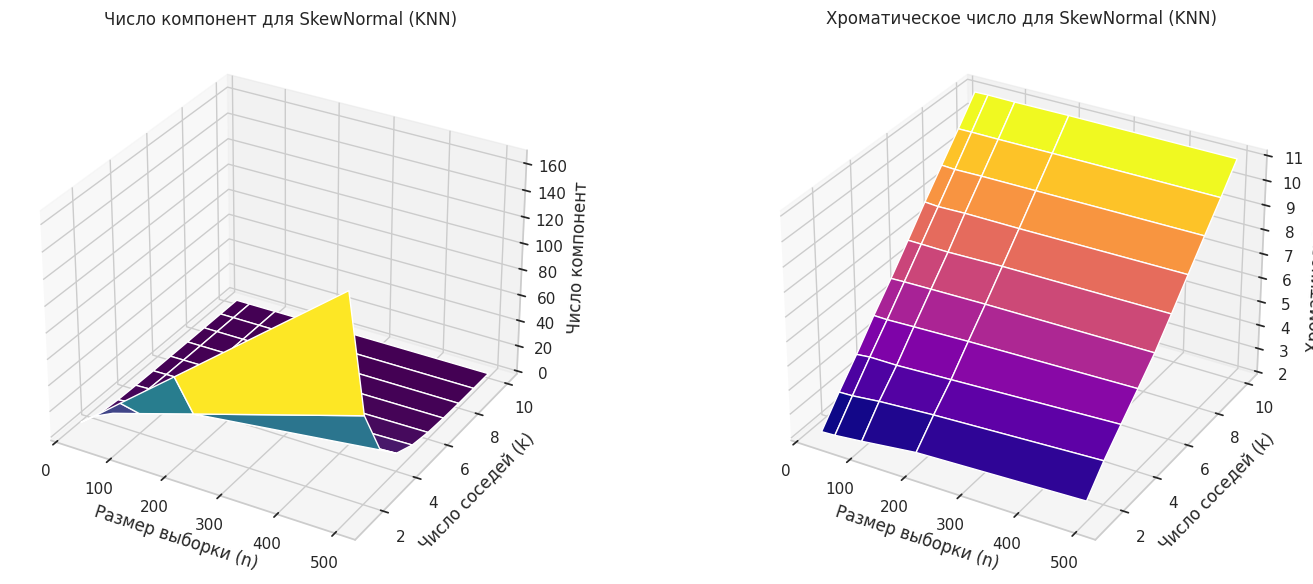

In [7]:

k_values = np.arange(1, 11)
n_values = [25, 50, 100, 200, 500]

X, Y = np.meshgrid(n_values, k_values)
Z_comp = np.zeros_like(X, dtype=float)
Z_chrom = np.zeros_like(X, dtype=float)

for i, n in enumerate(n_values):
    for j, k in enumerate(k_values):
        stats = monte_carlo_simulation('skewnorm', alpha0, n, 'knn', k, 200)
        Z_comp[j,i] = stats[:,0].mean()
        Z_chrom[j,i] = stats[:,1].mean()

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, Y, Z_comp, cmap='viridis')
ax1.set_xlabel('Размер выборки (n)')
ax1.set_ylabel('Число соседей (k)')
ax1.set_zlabel('Число компонент')
ax1.set_title('Число компонент для SkewNormal (KNN)')

ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, Y, Z_chrom, cmap='plasma')
ax2.set_xlabel('Размер выборки (n)')
ax2.set_ylabel('Число соседей (k)')
ax2.set_zlabel('Хроматическое число')
ax2.set_title('Хроматическое число для SkewNormal (KNN)')

plt.tight_layout()
plt.savefig('3d_visualization.png', dpi=300)
plt.show()

100%|██████████| 300/300 [00:01<00:00, 182.66it/s]


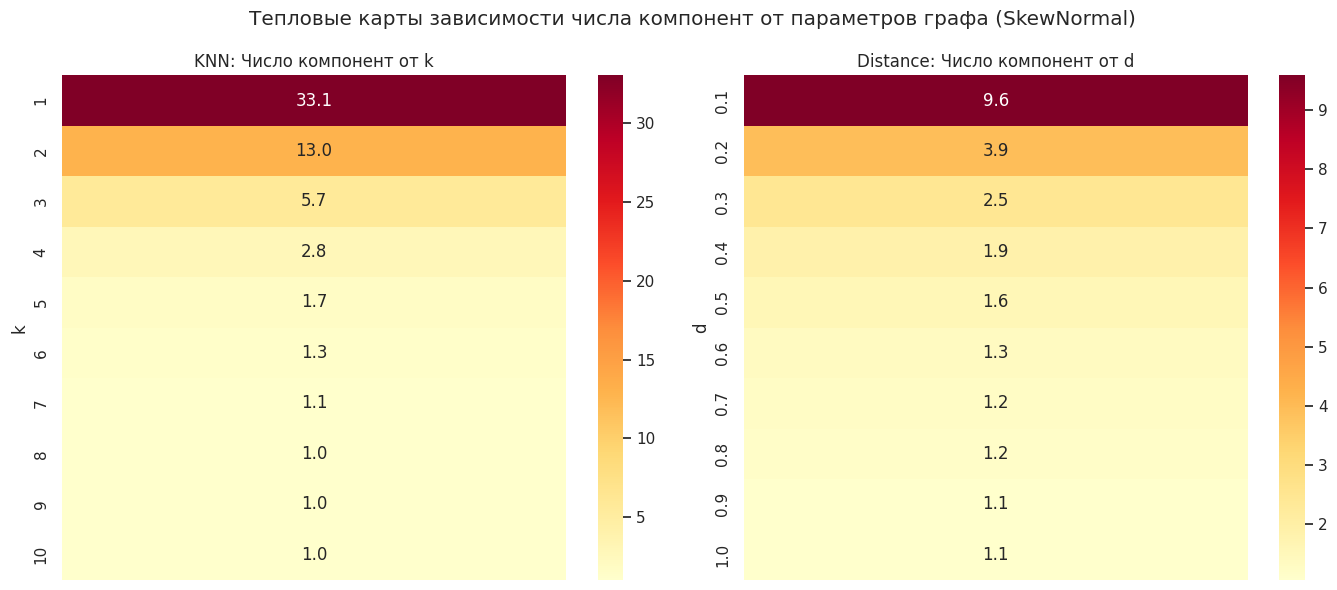

In [10]:

k_values = np.arange(1, 11)
d_values = np.linspace(0.1, 1.0, 10)


def create_heatmap_data(graph_type, param_values, stat_idx):
    data = []
    for param in param_values:
        if graph_type == 'knn':
            stats = monte_carlo_simulation('skewnorm', alpha0, 100, 'knn', param, 300)
        else:
            stats = monte_carlo_simulation('skewnorm', alpha0, 100, 'distance', param, 300)
        data.append(stats[:,stat_idx].mean())
    return np.array(data).reshape(len(param_values), 1)


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(create_heatmap_data('knn', k_values, 0),
            annot=True, fmt=".1f", cmap="YlOrRd",
            xticklabels=[], yticklabels=k_values)
plt.title('KNN: Число компонент от k')
plt.ylabel('k')

plt.subplot(1, 2, 2)
sns.heatmap(create_heatmap_data('distance', d_values, 0),
            annot=True, fmt=".1f", cmap="YlOrRd",
            xticklabels=[], yticklabels=[f"{d:.1f}" for d in d_values])
plt.title('Distance: Число компонент от d')
plt.ylabel('d')

plt.suptitle('Тепловые карты зависимости числа компонент от параметров графа (SkewNormal)')
plt.tight_layout()
plt.show()

100%|██████████| 500/500 [00:43<00:00, 11.43it/s]


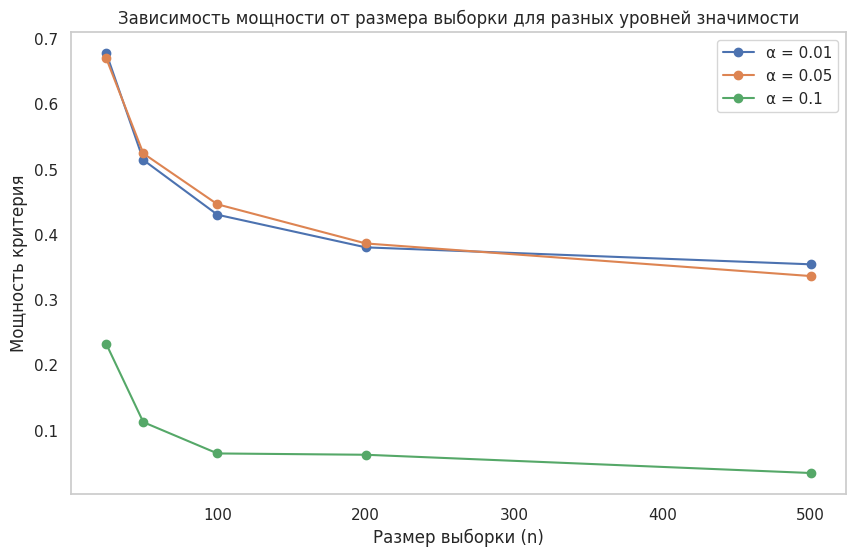

In [11]:
alpha_levels = [0.01, 0.05, 0.1]
n_values = [25, 50, 100, 200, 500]

plt.figure(figsize=(10, 6))

for alpha in alpha_levels:
    powers = []
    for n in n_values:
        stats_h0 = monte_carlo_simulation('laplace', beta0, n, 'distance', 0.5, 500)
        stats_h1 = monte_carlo_simulation('skewnorm', alpha0, n, 'distance', 0.5, 500)

        critical_value = np.percentile(stats_h0[:,0], 100*alpha)
        power = np.mean(stats_h1[:,0] > critical_value)
        powers.append(power)

    plt.plot(n_values, powers, 'o-', label=f'α = {alpha}')

plt.xlabel('Размер выборки (n)')
plt.ylabel('Мощность критерия')
plt.title('Зависимость мощности от размера выборки для разных уровней значимости')
plt.legend()
plt.grid()
plt.show()